In [3]:
from __future__ import print_function
import numpy as np
import pandas as pd
import lsst.syseng.throughputs as st
from lsst.sims.photUtils import PhotometricParameters, Sed
import galsim
import matplotlib.pyplot as plt

### We use Eq (6) in LSE-40. With the baseline system as defined by syseng_throughput (including hardware & atmosphere), We can easily map a source magnitude to a source count. This is not affected by seeing. Seeing comes into play because it determines how far to spread the total source count.

In [4]:
#The 3 fiducial atmosphere as defined by SRD Table 9.
fwhms = {'25':.44, '50':.60, '75':.80}

# full_well for a 30s visit, in e-
full_well = 150e3  #typical for e2v sensors. ITL is typically 200k. We try to be conservative and use the smaller.
full_well2 = 100e3  #some sensors can be as low as 100K e-.
bias_offset = 45e3
bias_offset_subtract = 0 #According to Steve R. and Aaron R., this should not be a factor

## We first determine what fraction of the flux will be in the center/brightest pixel
### Here for the atmosphereric PSF shape, we have assumed Kolmogorov. Currently Galsim doesn't provide Von Karman atmosphere profile. The difference between the two profiles, while the FWHM is the same, is expected to be small.

[0.08276032 0.0577153  0.03927402]


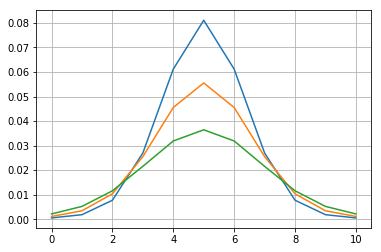

In [5]:
stamp_size = 11
pixel_scale = 0.2
ratio = np.zeros(3)
optics = galsim.Gaussian(fwhm=0.4)
for i, p in enumerate(fwhms):
    atm = galsim.Kolmogorov(fwhm=fwhms[p])
    psf = galsim.Convolve(atm, optics)
    img = galsim.ImageD(stamp_size, stamp_size, scale=pixel_scale)
    psf = psf.withFlux(1) #unit flux
    psf.drawImage(image=img)
    ratio[i] = img.array.max()/np.sum(img.array)
    plt.plot(img.array[5,:])
print(ratio)
plt.grid()

### Baseline LSST system, as defined in syseng_throughput

In [6]:
defaultDirs = st.setDefaultDirs()
hardware, system = st.buildHardwareAndSystem(defaultDirs)

### Default photometric parameters, as used in standard m5 calculations

In [7]:
exptime=15 
nexp=2
readnoise=8.8 
othernoise=0 
darkcurrent=0.2
effarea=np.pi*(6.423/2*100)**2
X=1.0

# PhotometricParameters object for standard m5 calculations.
photParams_std = PhotometricParameters(exptime=exptime, nexp=nexp,
                                           gain=1.0, effarea=effarea, readnoise=readnoise,
                                           othernoise=othernoise, darkcurrent=darkcurrent)

### Let's make sure we can reproduce standard m5 results

In [8]:
m5 = st.makeM5(hardware, system, darksky=None, 
                      exptime=exptime, nexp=nexp, readnoise=readnoise, othernoise=othernoise, darkcurrent=darkcurrent,
                      effarea=effarea, X=1.0)

In [9]:
m5

,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,0.92,0.80824,22.960730,80.840573,27.009181,0.035837,0.057997,0.522669,0.038185,23.165597,0.576230,0.362984,23.849238,550.932990,23.9,23.4
g,0.87,0.76714,22.257758,411.094794,28.399288,0.128938,0.154358,0.195371,0.038743,24.447490,0.176182,0.093056,24.840316,795.628429,25.0,24.6
r,0.83,0.73426,21.196590,818.797145,28.177407,0.105106,0.115690,0.104170,0.038990,24.467511,0.096081,0.047725,24.380855,990.243723,24.7,24.3
i,0.80,0.70960,20.477419,1173.487799,27.879556,0.079889,0.085493,0.073607,0.039101,24.363045,0.068928,0.033121,23.956774,1112.330543,24.0,23.6
z,0.78,0.69316,19.599578,1782.992383,27.481805,0.055384,0.057871,0.047694,0.039235,24.201828,0.046435,0.021447,23.384125,1306.751554,23.3,22.9
y,0.76,0.67672,18.610405,2371.023361,26.687500,0.026648,0.030944,0.162291,0.039311,23.759692,0.035324,0.015804,22.475605,1451.707778,22.1,21.7


### Set up the dataframe

In [10]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
properties = ['SatLim25', 'SatLim50','SatLim75']
d = pd.DataFrame(index=filterlist, columns=properties, dtype='float')

### Calculate the saturation limits

In [11]:
for f in system:
    flatsource = Sed()
    flatsource.setFlatSED(wavelen_min=system[f].wavelen_min, wavelen_max=system[f].wavelen_max,
                              wavelen_step=system[f].wavelen_step)
    adu = flatsource.calcADU(system[f], photParams=photParams_std)
    
    for i,p in enumerate(fwhms):
        adu0 = adu*ratio[i]
        key = 'SatLim%s'%p
        #because setFlatSED() assumes a m=0 star
        # we use gain=1.0, so adu = number of e-
        # we also get rid of skycounts from each pixel. This has miminal effect on results
        d[key].loc[f] = np.log10(adu0/(full_well-m5.skyCounts[f]-bias_offset_subtract))/2*5
        # The above can also be obtained this way, 
        # (but flatsource has to be re-initialized for each calculation)
        # Scale fnu so that adu0 is equal to full well.
        #flatsource.fnu = flatsource.fnu * (full_well/adu0)
        #d[key].loc[f] = flatsource.calcMag(system[f])

In [12]:
d.join(m5)

,SatLim25,SatLim50,SatLim75,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,15.056897,14.665569,14.247605,0.92,0.80824,22.960730,80.840573,27.009181,0.035837,0.057997,0.522669,0.038185,23.165597,0.576230,0.362984,23.849238,550.932990,23.9,23.4
g,16.449399,16.058071,15.640106,0.87,0.76714,22.257758,411.094794,28.399288,0.128938,0.154358,0.195371,0.038743,24.447490,0.176182,0.093056,24.840316,795.628429,25.0,24.6
r,16.230481,15.839153,15.421189,0.83,0.73426,21.196590,818.797145,28.177407,0.105106,0.115690,0.104170,0.038990,24.467511,0.096081,0.047725,24.380855,990.243723,24.7,24.3
i,15.935214,15.543886,15.125921,0.80,0.70960,20.477419,1173.487799,27.879556,0.079889,0.085493,0.073607,0.039101,24.363045,0.068928,0.033121,23.956774,1112.330543,24.0,23.6
z,15.541918,15.150590,14.732626,0.78,0.69316,19.599578,1782.992383,27.481805,0.055384,0.057871,0.047694,0.039235,24.201828,0.046435,0.021447,23.384125,1306.751554,23.3,22.9
y,14.751930,14.360602,13.942638,0.76,0.67672,18.610405,2371.023361,26.687500,0.026648,0.030944,0.162291,0.039311,23.759692,0.035324,0.015804,22.475605,1451.707778,22.1,21.7


### It may be easier to reference the results if we use the zeropoints (the AB mag of the source that produces 1 e- per second on the detector)

In [13]:
d_zp = pd.DataFrame(index=filterlist, columns=properties, dtype='float')
for f in system:
    for i,p in enumerate(fwhms):
        key = 'SatLim%s'%p
        #number of electrons we can accomodate for the source in 30 sec
        ne = (full_well-m5.skyCounts[f]-bias_offset_subtract)/ratio[i]
        #number of electrons we can accomodate for this source in 1 sec
        ne = ne/(exptime*nexp)
        d_zp[key].loc[f] = (m5.Zp_t[f]-2.5*np.log10(ne))

In [14]:
round(d_zp - d)  #should be idential to above calculations

,SatLim25,SatLim50,SatLim75
u,0.0,0.0,0.0
g,-0.0,0.0,-0.0
r,0.0,0.0,0.0
i,0.0,-0.0,0.0
z,-0.0,-0.0,-0.0
y,-0.0,0.0,-0.0


### For making the plot below, we only use FWHM of atmosphere of 0.6 arcsec, so that the PSF is 0.7 arcsec in FWHM

In [15]:
pRatio = ratio[properties.index('SatLim50')]
colors = ['blue', 'green', 'red', '0.75', '0.50', '0.25']
d_plot = pd.DataFrame(index=filterlist, columns=['SatLimFromPlot'], dtype='float')

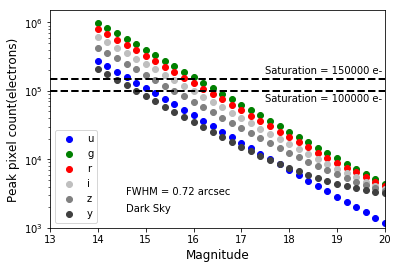

In [16]:
fig, ax = plt.subplots()
for i,f in enumerate(filterlist):
    mags = []
    npeaks = []
    flatsource = Sed()
    flatsource.setFlatSED(wavelen_min=system[f].wavelen_min, wavelen_max=system[f].wavelen_max,
                              wavelen_step=system[f].wavelen_step)
    adu = flatsource.calcADU(system[f], photParams=photParams_std)
    adu0 = adu*pRatio #a m=0 start produces this adu0 in the center pixel
    for m in range(31):
        mag = 14.0 + 0.2 * m
        mags.append(mag)
        npeak = adu0*10**(-mag/2.5)+m5.skyCounts[f]+bias_offset_subtract
        npeaks.append(npeak)
    plt.scatter(mags, npeaks, label=f, color=colors[i])
    #print(npeak)
    #break
    d_plot.SatLimFromPlot.loc[f] = mags[np.argmax(np.array(npeaks)<full_well)]
plt.plot([13.0,20.0],[full_well, full_well], ls = '--', lw = 2, color='black')
plt.text(17.5, full_well*1.20, "Saturation = %d e-"%full_well, color = 'black')
plt.plot([13.0,20.0],[full_well2, full_well2], ls = '--', lw = 2, color='black')
plt.text(17.5, full_well2*0.7, "Saturation = %d e-"%full_well2, color = 'black')
plt.text(0.3, 0.24, "FWHM = %.2f arcsec"%(np.sqrt(fwhms['50']**2+0.4**2)), color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.18, "Dark Sky", color = 'black', transform=fig.transFigure)
plt.legend()
plt.yscale('log')
plt.xlim(13.0,20.0)
plt.ylim(1e3, 1.5e6)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Peak pixel count(electrons)', fontsize=12);

In [17]:
#check consistency with above calculations.
d_plot.join(d)

,SatLimFromPlot,SatLim25,SatLim50,SatLim75
u,14.8,15.056897,14.665569,14.247605
g,16.2,16.449399,16.058071,15.640106
r,16.0,16.230481,15.839153,15.421189
i,15.6,15.935214,15.543886,15.125921
z,15.2,15.541918,15.150590,14.732626
y,14.4,14.751930,14.360602,13.942638


#### If we had subtracted the bias offset, how much does it reduce the dynamic range (in magnitude)?

In [18]:
np.log10(full_well/(full_well-bias_offset))*2.5

0.3872548999643579

### We can use the zeropoints to do the same calculations and make the same plot

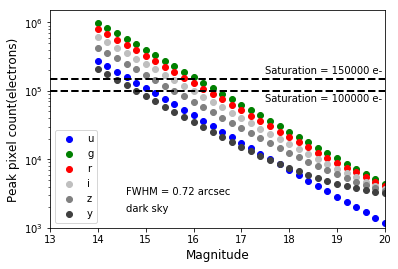

In [19]:
d_plot_zp = pd.DataFrame(index=filterlist, columns=['SatLimFromPlot'], dtype='float')
fig, ax = plt.subplots()
for i,f in enumerate(filterlist):
    mags = []
    npeaks = []
    for m in range(31):
        mag = 14.0 + 0.2 * m
        mags.append(mag)
        #for a source of mag, how many electrons is produced on detector in a second?
        ne = 10**((m5.Zp_t[f] - mag)/2.5)
        # what about 30 seconds
        ne *= exptime*nexp
        # how many fall into the center pixel? on top of the background and others
        npeak = ne*pRatio+ m5.skyCounts[f]+bias_offset_subtract
        npeaks.append(npeak)
        d_plot_zp.SatLimFromPlot.loc[f] = mags[np.argmax(np.array(npeaks)<full_well)]
    plt.scatter(mags, npeaks, label=f, color=colors[i])
    #print(npeak)
    #break
plt.plot([13.0,20.0],[full_well, full_well], ls = '--', lw = 2, color='black')
plt.text(17.5, full_well*1.20, "Saturation = %d e-"%full_well, color = 'black')
plt.plot([13.0,20.0],[full_well2, full_well2], ls = '--', lw = 2, color='black')
plt.text(17.5, full_well2*0.7, "Saturation = %d e-"%full_well2, color = 'black')
plt.text(0.3, 0.24, "FWHM = %.2f arcsec"%(np.sqrt(fwhms['50']**2+0.4**2)), color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.18, "dark sky", color = 'black', transform=fig.transFigure)
plt.legend()
plt.yscale('log')
plt.xlim(13.0,20.0)
plt.ylim(1e3, 1.5e6)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Peak pixel count(electrons)', fontsize=12)
plt.savefig('Peak_count_by_band_darkSky.pdf')

In [20]:
round(d_plot - d_plot_zp) #should be identical to calculations using zero points

,SatLimFromPlot
u,0.0
g,0.0
r,0.0
i,0.0
z,0.0
y,0.0


#### Now do the same thing for bright sky. We will only do the calculations using zero points below.

In [21]:
#to make sure we add the 0.4 mag to the sky correctly, let's verify we can use darksky mag to reproduce dark sky count
# can we use the zero point to do that?
for f in system:
    print(f, m5.Zp_t[f], m5.skyMag[f], 10**((m5.Zp_t[f] - m5.skyMag[f])/2.5)*30*0.2*0.2, m5.skyCounts[f])
#The answer is no. The reason is because the zero point contains effect of atmosphere+hardware. 
#The photons produced by a certain sky mag only go through the hardware, not atmosphere

u 27.009181343298994 22.960730180229127 49.953015613436925 80.84057283788833
y 26.68750015086725 18.61040493721628 2041.8288294344675 2371.0233609078164
g 28.39928844119809 22.257757986434328 343.3945735171815 411.09479401436244
r 28.17740748284969 21.19658987481676 743.8892611843139 818.7971449187912
z 27.481804922032165 19.599578356350023 1706.3647555820953 1782.9923826362085
i 27.879555761190304 20.477418932398777 1096.5690336979158 1173.4877990365458


In [22]:
import os
from lsst.utils import getPackageDir
def skyMag2Count(skyMag, f, hardware, photParams):
    '''
    inputs:
        skyMag is the sky magnitude
        f is the filter band
        hardware: an bandpass object as defined in the syseng_throughput package
        photParams: an PhotometricParameters object as defined in the syseng_throughput package
    output:
        skycount in each pixel
    '''
    darksky = Sed()
    darksky.readSED_flambda(os.path.join(getPackageDir('syseng_throughputs'),
                                             'siteProperties', 'darksky.dat'))
    fNorm = darksky.calcFluxNorm(skyMag, hardware)
    darksky.multiplyFluxNorm(fNorm)
    skyCount = (darksky.calcADU(hardware, photParams=photParams)* photParams.platescale**2)
    return fNorm, skyCount

In [23]:
# Now we can reproduce m5 sky count with m5 sky mag, we are confident to proceed
for f in system:
    fNorm, skyCount = skyMag2Count(m5.skyMag[f], f, hardware[f], photParams_std)
    print(f, fNorm, skyCount, m5.skyCounts[f])

u 1.0 80.84057283788833 80.84057283788833
y 1.0 2371.0233609078164 2371.0233609078164
g 1.0 411.09479401436244 411.09479401436244
r 1.0 818.7971449187912 818.7971449187912
z 1.0 1782.9923826362085 1782.9923826362085
i 1.0 1173.4877990365458 1173.4877990365458


skyBrightMag below is sky brightness at 50 deg from full moon (based on DeCam experience)

Tony wrote :

Even the 
11 yr solar cycle gives 0.5 mag change in v band.  For our immediate 
SpaceX purpose it would be appropriate to generate only two plots, one 
for bright time and one for dark time.  In the mid 2020s we enter solar 
max, so add 0.4 mag in v band to sky.

In [24]:
skyBrightMag = {'u': 17.7, 'g':19.4, 'r':19.7, 'i':19.4, 'z':18.2, 'y':17.7}

In [25]:
skyCounts = {}
for f in system:
    skyCount = 10**((0.4+m5.skyMag[f]-skyBrightMag[f])/2.5)*m5.skyCounts[f] # we can actually simply calculate sky count this way.
    skyCounts[f]=skyCount
    fNorm, skyCount1 = skyMag2Count(skyBrightMag[f]-0.4, f, hardware[f], photParams_std)
    print('%s, %.2f, %.2f, %.2f'%(f, skyCount, skyCount1, skyCount-skyCount1)) # this is just to double check

u, 14856.67, 14856.67, -0.00
y, 7926.80, 7926.80, 0.00
g, 8261.24, 8261.24, 0.00
r, 4696.91, 4696.91, -0.00
z, 9353.64, 9353.64, -0.00
i, 4575.58, 4575.58, -0.00


In [26]:
skyCounts

{'u': 14856.66923227248,
 'y': 7926.79830507322,
 'g': 8261.238714700821,
 'r': 4696.910335856309,
 'z': 9353.643864016844,
 'i': 4575.579983868398}

In [27]:
#use zero points to calculate saturation magnitudes under bright sky
d_zp_bright = pd.DataFrame(index=filterlist, columns=properties, dtype='float')
for f in system:
    for i,p in enumerate(fwhms):
        key = 'SatLim%s'%p
        #number of electrons we can accomodate for the source in 30 sec
        ne = (full_well-skyCounts[f]-bias_offset_subtract)/ratio[i]
        #number of electrons we can accomodate for this source in 1 sec
        ne = ne/(exptime*nexp)
        d_zp_bright[key].loc[f] = (m5.Zp_t[f]-2.5*np.log10(ne))

In [28]:
d_zp_bright

,SatLim25,SatLim50,SatLim75
u,15.169553,14.778225,14.360261
g,16.507925,16.116597,15.698633
r,16.259079,15.867751,15.449787
i,15.960321,15.568993,15.151029
z,15.598842,15.207514,14.789550
y,14.793578,14.402250,13.984286


In [29]:
d_zp_bright - d_zp

,SatLim25,SatLim50,SatLim75
u,0.112656,0.112656,0.112656
g,0.058527,0.058527,0.058527
r,0.028598,0.028598,0.028598
i,0.025107,0.025107,0.025107
z,0.056924,0.056924,0.056924
y,0.041649,0.041649,0.041649


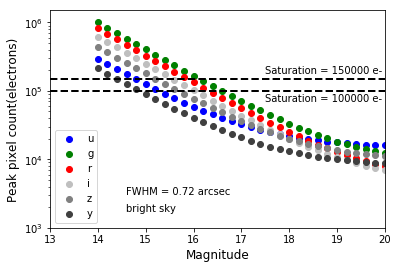

In [30]:
d_plot_zp_bright = pd.DataFrame(index=filterlist, columns=['SatLimFromPlot'], dtype='float') # b for bright sky
fig, ax = plt.subplots()
for i,f in enumerate(filterlist):
    mags = []
    npeaks = []
    for m in range(31):
        mag = 14.0 + 0.2 * m
        mags.append(mag)
        #for a source of mag, how many electrons is produced on detector in a second?
        ne = 10**((m5.Zp_t[f] - mag)/2.5)
        # what about 30 seconds
        ne *= exptime*nexp
        # how many fall into the center pixel? on top of the background and others
        npeak = ne*pRatio+ skyCounts[f]+bias_offset_subtract
        npeaks.append(npeak)
        d_plot_zp_bright.SatLimFromPlot.loc[f] = mags[np.argmax(np.array(npeaks)<full_well)]
    plt.scatter(mags, npeaks, label=f, color=colors[i])
    #print(npeak)
    #break
plt.plot([13.0,20.0],[full_well, full_well], ls = '--', lw = 2, color='black')
plt.text(17.5, full_well*1.20, "Saturation = %d e-"%full_well, color = 'black')
plt.plot([13.0,20.0],[full_well2, full_well2], ls = '--', lw = 2, color='black')
plt.text(17.5, full_well2*0.7, "Saturation = %d e-"%full_well2, color = 'black')
plt.text(0.3, 0.24, "FWHM = %.2f arcsec"%(np.sqrt(fwhms['50']**2+0.4**2)), color = 'black', transform=fig.transFigure)
plt.text(0.3, 0.18, "bright sky", color = 'black', transform=fig.transFigure)
plt.legend()
plt.yscale('log')
plt.xlim(13.0,20.0)
plt.ylim(1e3, 1.5e6)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Peak pixel count(electrons)', fontsize=12)
plt.savefig('Peak_count_by_band_brightSky.pdf')

In [31]:
d_plot_zp_bright - d_plot_zp

,SatLimFromPlot
u,0.0
g,0.0
r,0.0
i,0.0
z,0.2
y,0.2
